In [1]:
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import save_image
from IPython.display import display, clear_output
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
%matplotlib inline

In [2]:
batch_size = 1024

# downloads train set of MNIST data
train_data = MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
# makes dataloader from train set
train_dl = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# downloads test set of MNIST data
test_data = MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)
# creates dataloader for test set
# test set will not be used to train the auto encoder
test_dl = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

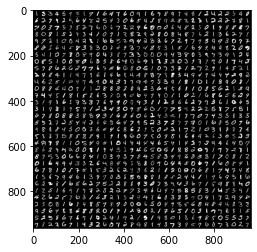

tensor([[1, 3, 3,  ..., 6, 0, 9],
        [1, 6, 9,  ..., 5, 4, 0],
        [6, 2, 7,  ..., 0, 6, 5],
        ...,
        [3, 1, 4,  ..., 5, 5, 7],
        [7, 8, 2,  ..., 2, 8, 9],
        [8, 1, 4,  ..., 0, 2, 7]])


In [3]:
img, label = iter(train_dl).next()
grid_img = torchvision.utils.make_grid(img, nrow=32)
plt.imshow(grid_img.permute(1,2,0))
plt.show()
print(label.view(-1, 16))

In [4]:
nc = 1
ndf = 4
ngf = 4
nz = 7
class CAutoEncoder(nn.Module):
    def __init__(self):
        super(CAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            # input is (nc) x 28 x 28
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 14 x 14
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 7 x 7
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 3 x 3
            nn.Conv2d(ndf*4, 7, 3, 1, 0, bias=False),
            nn.Tanh()
            # state size 7 x 1 x 1
        )
        self.decoder = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 3 x 3
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False, output_padding = 1),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 7 x 7
            nn.ConvTranspose2d( ngf * 2, ngf , 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 14 x 14
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.ReLU(True),
            # state size. (nc) x 28 x 28
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [5]:
ndf = 4
m = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 3 x 3
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False, output_padding = 1),
        )

In [6]:
m(torch.randn(10,7,1,1))[0].shape

torch.Size([8, 7, 7])

In [7]:
learning_rate = 1e-5
num_epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CAutoEncoder().to(device)
lossfn = nn.MSELoss() #MSE loss because we will be directly comparing images and not the labels
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-6)

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

model.apply(weights_init)

CAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(16, 7, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): Tanh()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(7, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride

In [12]:
istrained = False
model.load_state_dict(torch.load("Cautoencoder.torch",map_location=torch.device('cpu')))
model.eval()
istrained = True
    
if not istrained:
    for epoch in range(num_epochs):
        for data in train_dl:
            clear_output(wait=True)
            img, _ = data
            imgc = img.to(device)

            output = model(imgc)
            loss = lossfn(output, imgc)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # uncomment to see the output converge, slows down training
    #         pic = to_img(output.cpu().data)
    #         grid_img = torchvision.utils.make_grid(pic, nrows=16)
    #         plt.imshow(grid_img.permute(1, 2, 0))
    #         plt.show()

            print("epoch [{}/{}], loss: {:.4f}".format(epoch+1, num_epochs, loss.data))
        pic = to_img(output.cpu().data)
        save_image(pic, "./training/img_{}.png".format(epoch))

In [13]:
# freezing model parameter, encoder parameter will not be a part of gradient update

for param in model.parameters():
    param.requires_grad = False
torch.save(model.state_dict(), "Cautoencoder.torch")

# uncomment to load model from saved file
# model = AutoEncoder()
# model.load_state_dict(torch.load("./sim_autoencoder.pth"))
# model.eval()

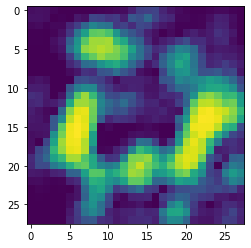

KeyboardInterrupt: 

In [14]:
model.to(device)
import time
for i in range(100):
  plt.imshow(model.decoder(torch.randn(1,7,1,1).to(device)).to("cpu").reshape(28,28))
  clear_output(wait=True)
  plt.show(block=False)
  time.sleep(2)

In [15]:
# batchwise_mle = []
# i=0
# for data in train_dl:
#   img, label = data
#   latent_output = model.encoder(img.cuda()).cpu().numpy()[label==2].reshape(-1,7)
#   i+=1
#   print(i)
#   batchwise_mle.append((np.mean(latent_output, axis=0), np.cov(latent_output.T)))

# now we will create another dataloader xd
fullmean = 0
fullcovar = 0
train_full = DataLoader(dataset=train_data, batch_size=len(train_data), shuffle=True)
for data in train_full:
  img, label = data
  model_out = model.encoder(img.to(device)).cpu().numpy().reshape(-1,7)
  latent_output = model_out[label==2]
  fullmean = np.mean(latent_output, axis = 0)
  fullcovar = np.cov(latent_output.T)

In [16]:
ldamodel = LDA(n_components = 2)
# keeping it 2 for visualization, 3 is amazing!

ldamodel.fit(model_out, label)

LinearDiscriminantAnalysis(n_components=2)

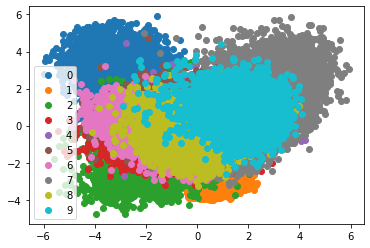

In [17]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# # data_dump = []
# dim2train = ldamodel.transform(model_out)
# for i in range(10):
#   dim2trainC = dim2train[label==i]
#   x = dim2trainC[:,[0]]
#   y = dim2trainC[:,[1]]
#   z = dim2trainC[:,[2]]
#   # data_dump.append((x,y,z))
#   ax.scatter3d(x,y,z, label=str(i));
# plt.legend()
# import pickle
# pickle.dump(data_dump, open("fulldata.plt", "wb"))
# plt.show()

# using lower dim for easier vis | interested may unable the commented code above
# our latent space is 3d though
dim2train = ldamodel.transform(model_out)
for i in range(10):
  dim2trainC = dim2train[label==i]
  x = dim2trainC[:,[0]]
  y = dim2trainC[:,[1]]
  plt.scatter(x,y, label=str(i));
plt.legend()


In [27]:
generated = np.random.multivariate_normal(fullmean,fullcovar, 128)

#notice, instead of fullmean and full covar, if classwise mean and covar a sent, the model successfully predicts it

In [28]:
latentin = torch.tensor(generated.reshape(-1,7,1,1), device=device, dtype=torch.float32)

In [29]:
ae_out = model.decoder(latentin)

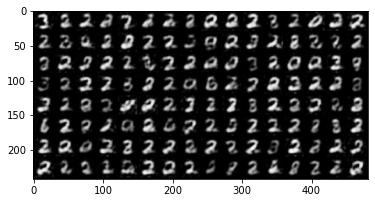

In [30]:
grid_img = torchvision.utils.make_grid(ae_out.cpu(), nrow=16)
plt.imshow(grid_img.permute(1,2,0))
plt.show()

In [31]:
ldamodel.predict(generated)

array([3, 2, 2, 2, 7, 6, 6, 2, 2, 2, 2, 1, 2, 6, 2, 2, 2, 2, 6, 2, 2, 2,
       2, 2, 4, 2, 2, 2, 2, 2, 1, 2, 8, 2, 2, 2, 2, 6, 2, 2, 6, 0, 7, 2,
       0, 2, 2, 9, 5, 2, 2, 2, 5, 2, 2, 2, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 8, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 6, 2, 8, 2, 2, 2, 6, 2,
       2, 2, 2, 2, 2, 8, 3, 2, 2, 2, 6, 2, 8, 2, 2, 2, 2, 2, 2, 5, 2, 2,
       2, 2, 2, 6, 2, 2, 2, 2, 2, 2, 2, 8, 2, 6, 8, 2, 2, 2], dtype=int64)